# IMPORTS

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from scipy import linalg
from sklearn.cluster import KMeans
from pyunlocbox import functions, solvers
import networkx as nx

In [17]:
ADJACENCY_PATH = 'data/adjacency_matrices/'
MEMBER_ID_PATH = 'data/member_matrices/member_id_party'

In [18]:
rawvotes = pd.read_pickle("data/votes.pickle")
rawvotes.head()

,id,bill.number,congress,member_id,question,position,timestamp
0,hr6-115-221,H.R.6,115,A000360,On the Motion,1,2018-10-03 15:18:00
1,hr302-115-220,H.R.302,115,A000360,On the Motion,1,2018-10-03 12:01:00
2,hr302-115-219,H.R.302,115,A000360,On the Cloture Motion,1,2018-10-01 17:31:00
3,pn1677-115-218,PN1677,115,A000360,On the Nomination,1,2018-09-27 12:41:00
4,pn2073-115-217,PN2073,115,A000360,On the Nomination,1,2018-09-26 13:46:00


# FEATURE SELECTION

In [19]:
NOMINATION_VOTE = "On the Nomination"
MOTION_VOTE = "On the Motion"
AMENDMENT_VOTE = "On the Amendment"
MOTION_TO_TABLE_VOTE = "On the Motion to Table"
CLOTURE_MOTION_VOTE = "On the Cloture Motion"
BILL_PASSAGE = "On Passage of the Bill"

def build_vote_matrix(questions, data):
    """
    Given a list of questions, build a vote matrix.
    Index are senators IDs, columns are vote IDs and values are the respective positions
    of the senators with respect to the question (Yes, No, blank or NaN if the senator
    did not take part in the vote)
    
    Data should contain the following columns:
        - senators ID (member_id)
        - vote ID (id)
        - position (position)
    """    
    
    vote_matrix = data 
    
    if len(questions) > 0:
        vote_matrix = data[data['question'].isin(questions)]
        
    vote_matrix = vote_matrix.pivot(columns='id', index='member_id', values='position')
    
    return vote_matrix

vote_matrix = build_vote_matrix([BILL_PASSAGE, AMENDMENT_VOTE], rawvotes).dropna(0)
print(vote_matrix.shape)
vote_matrix.head()

(96, 77)


id,hconres71-115-220,hconres71-115-221,hconres71-115-222,hconres71-115-223,hconres71-115-225,hconres71-115-226,hconres71-115-228,hconres71-115-229,hconres71-115-230,hconres71-115-232,...,s2554-115-208,s2554-115-209,s722-115-144,s722-115-145,s722-115-146,s722-115-147,s84-115-27,s89-115-102,sconres3-115-20,sconres3-115-3
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,1,-1,-1,1,-1,1,-1,1,-1,-1,...,-1,1,1,1,1,1,0,1,-1,-1
B000575,0,0,0,0,-1,1,-1,1,-1,-1,...,-1,1,1,1,1,1,1,1,-1,0
B000944,1,1,1,1,1,-1,1,1,1,1,...,-1,1,1,1,1,1,1,1,1,-1
B001135,1,-1,-1,1,-1,1,-1,1,-1,-1,...,-1,1,1,1,1,1,1,1,-1,-1
B001230,1,1,1,1,1,-1,1,1,1,1,...,-1,1,1,1,1,1,-1,1,1,-1


In [20]:
bill_matrix = pd.read_pickle("data/member_matrices/member_to_bill_sponsoring.pickle").dropna(0)
print(bill_matrix.shape)
bill_matrix.head()

(104, 1110)


a,sconres55-115,sconres56-115,sres712-115,sconres54-115,sres710-115,sres709-115,s3661-115,sres704-115,sres706-115,sres705-115,...,sres1-115,sres2-115,sres3-115,sconres2-115,sconres1-115,sconres3-115,s12-115,sres4-115,s19-115,sjres1-115
A000360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B000575,1,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
B000944,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
B001135,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
B001230,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [824]:
def build_commities_matrix(raw_commities):
    res = raw_commities.copy()
    res['halfcommittee'] =  res['comitee'].map(str)
    res['pos'] = 1
    res = res.drop_duplicates(['id','halfcommittee'])
    res = res.pivot(columns = 'halfcommittee',index='id', values='pos')
    res = res.fillna(0)
    return res

rawcommitees = pd.read_csv("data/commitees/commitees_115/members.csv")
committees_matrix = build_commities_matrix(rawcommitees) 

In [826]:
print(committees_matrix.shape)
committees_matrix.head()

(97, 12)


halfcommittee,SSAF,SSAP,SSAS,SSBK,SSCM,SSEG,SSEV,SSFI,SSFR,SSGA,SSHR,SSJU
id,,,,,,,,,,,,
A000360,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
B000575,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000944,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
B001135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
B001230,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [827]:
common_senators = vote_matrix.index.intersection(bill_matrix.index.intersection(committees_matrix.index))
vote_matrix = vote_matrix.loc[common_senators]
bill_matrix = bill_matrix.loc[common_senators]
committees_matrix = committees_matrix.loc[common_senators]

In [828]:
print(vote_matrix.shape)
print(bill_matrix.shape)
print(committees_matrix.shape)

(95, 77)
(95, 1110)
(95, 12)


In [829]:
raw_senators = pd.read_csv("data/senate_members/senate_members_115.csv")[['id', 'party']].set_index('id')
senators = raw_senators.loc[common_senators]
np.save(MEMBER_ID_PATH, senators['party'].values)
print(senators.iloc[40])
print(senators.iloc[83])

party    D
Name: H001046, dtype: object
party    R
Name: T000250, dtype: object


# ---

In [865]:
def euclidean_distance(x,y):
    """
    Given two vectors of the same length, return the euclidean distance between the two vectors.
    """
    return np.sqrt(np.sum(np.power(x-y,2)))

def hamming_distance(x,y):
    """
    Given two vectors of the same length, return the hamming distance betweem the two vectors.
    """
    a = x != y
    return a.sum()

def cosine_similarity(x,y):
    """
    Given two vectors of the same length, return the cosine similarity betweem the two vectors.
    """
    return 0.5 * (1 + (np.dot(x,y))/(np.linalg.norm(x)*np.linalg.norm(y)))

def gaussian_kernel(distance_matrix):
    """
    Given a matrix calculate the gaussian kernel of it. The variance is given by the mean of the matrix. 
    """
    kernel_width = distance_matrix.mean()
    res = np.exp(-distance_matrix**2 / kernel_width**2)
    return res

def linear_kernel(distance_matrix):
    """
    Given a matrix calculate the linear kernel of it.
    """
    max_adj = np.max(distance_matrix)
    min_adj = np.min(distance_matrix)
    res = 1 - (distance_matrix - min_adj)/(max_adj-min_adj)
    return res

def identity_kernel(distance_matrix):
    """
    Given a matrix calculate the indentity kernel of it. The indentity kernel will not change the matrix.
    """
    return distance_matrix

def sparsify_with_limit(adjacency, limit = 0.35):
    """
    Sparsify a matrix by putting each of element of the adjacency matrix to 0
    if it is below the limit.
    """
    res = adjacency.copy()
    res[res < limit] = 0
    return res

def sparsify_with_neg_limit(adjacency, limit = 0.35):
    """
    Sparsify a matrix by putting each of element of the adjacency matrix to 0
    if it is below the limit.
    """
    res = adjacency.copy()
    res[res > limit] = 0
    return res

def sparsify_with_max_neighbors(adjacency, max_neighbors = 45):
    """
    Sparsify a matrix by greedily adding the links of higher weight such that each node
    doesn't have more neighbors than max_neighbors 
    """
    number_of_nodes = adjacency.shape[0]    
    
    index_sort = np.argsort(adjacency,axis=None)[::-1]
    flatten_adjacency = adjacency.flatten()
    res = np.zeros(adjacency.shape)
    counter = 0

    for i in range(len(index_sort)):
        if counter >= max_neighbors * number_of_nodes:
            break
        
        node_1 = index_sort[i] % number_of_nodes
        node_2 = int(index_sort[i] / number_of_nodes)

        if(np.count_nonzero(res[node_1]) < max_neighbors and np.count_nonzero(res[node_2]) < max_neighbors):
            res[node_1,node_2] = flatten_adjacency[index_sort[i]]
            res[node_2,node_1] = flatten_adjacency[index_sort[i]]
            counter += 1
                   
    return res

In [866]:
def get_adjacency_multidistance(features_list, weights, distance_function, kernel_function, sparsify):
    
    number_of_nodes = features_list[0].shape[0]
    result = np.zeros((number_of_nodes, number_of_nodes))
    
    for i, features in enumerate(features_list):
        distance_matrix = np.asarray(
        [
            [distance_function(features[i],features[j]) for j in range(number_of_nodes)] 
            for i in range(number_of_nodes)
        ])    
        kernel = kernel_function(distance_matrix)
        np.fill_diagonal(kernel, 0)
        
        result += weights[i] * sparsify[i](kernel)
        
    return result  

In [867]:
def get_counted_adjacency(features):
    similarity_count = np.zeros((features.shape[0], features.shape[0]))
    
    for sen in range(features.shape[0]):
        for other in range(features.shape[0]):

            if sen == other:
                continue

            similarities = features[sen] == features[other]
            similarity_count[sen, other] = np.sum(similarities * ~np.isclose(features[sen], 0))

    min_ = np.min(similarity_count)
    max_ = np.max(similarity_count)
    similarity_count = (similarity_count - min_)/(max_ - min_)
                    
    return similarity_count

In [929]:
get_adjacency_multidistance(
    [vote_matrix.values, bill_matrix.values, committees_matrix.values],
    weights,
    cosine_similarity,
    identity_kernel,
    [lambda arg : sparsify_with_limit(arg,0.715),
    lambda arg : sparsify_with_limit(arg,0.715),
    lambda arg : sparsify_with_limit(arg,0.715)]
)
print()

# SIMILARITY GRAPH CONSTRUCTION

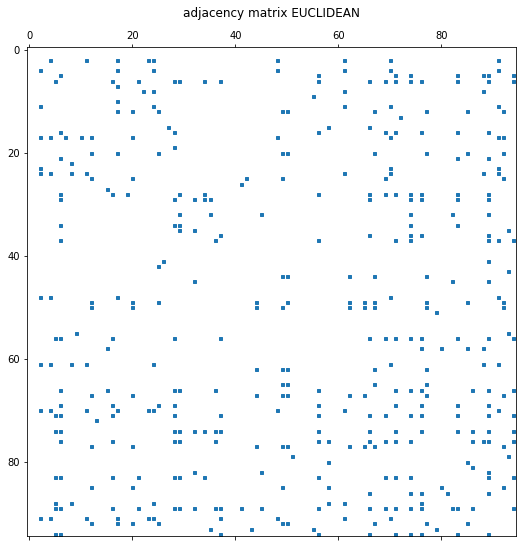

In [923]:
weights = [1,0,1]

counted_votes = sparsify_with_limit(get_counted_adjacency(vote_matrix.values.astype(int)),0.95)
counted_bills = sparsify_with_limit(get_counted_adjacency(bill_matrix.values.astype(int)),0.8)
counted_committees = sparsify_with_limit(get_counted_adjacency(committees_matrix.values.astype(int)), 0.53)

adjacency = np.average([counted_votes, counted_bills, counted_committees], weights=weights, axis=0)
adjacency = sparsify_with_limit(adjacency, 0.0)

np.save("data/adjacency_matrices/mixed.npy", adjacency)

plt.figure(figsize=(9,9))
plt.spy(adjacency, markersize=3)
plt.title('adjacency matrix EUCLIDEAN')
plt.show()

In [924]:
node_degrees = np.count_nonzero(adjacency, axis=1)
nodes_to_keep = np.nonzero(node_degrees)[0]

adjacency = adjacency[np.ix_(nodes_to_keep, nodes_to_keep)]

D = np.diag(adjacency.sum(1))
A = adjacency
laplacian_combinatorial = D - A
np.save("data/matrices/laplacian", laplacian_combinatorial)
D_half = sc.linalg.fractional_matrix_power(D, -0.5)
laplacian_normalized =  D_half @ laplacian_combinatorial @ D_half

laplacian = laplacian_normalized

eigenvalues,eigenvectors =  sc.linalg.eigh(laplacian)

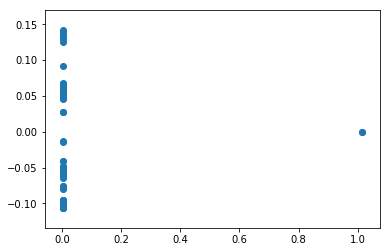

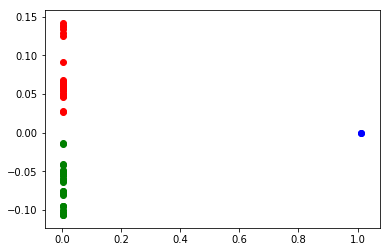

In [925]:
def embed(laplacian,d):
    eigenvalues,eigenvectors =  sc.linalg.eigh(laplacian)
    indexes = np.argsort(eigenvalues)

    return eigenvectors[:,1:1+d]

k = 3
def gen_kmeans(k,eigenvectors,random_state = 42):
    means = KMeans(n_clusters=k, random_state=random_state).fit(eigenvectors)
    return means.labels_

embedding =  D_half @ embed(laplacian, 2)
plt.scatter(embedding[:,0],embedding[:,1])
plt.show()
clusters = gen_kmeans(k,embedding)

colors = ['r','b','g']

for i in range(len(embedding)):
    plt.scatter(embedding[i,0], embedding[i,1], color=colors[clusters[i]])

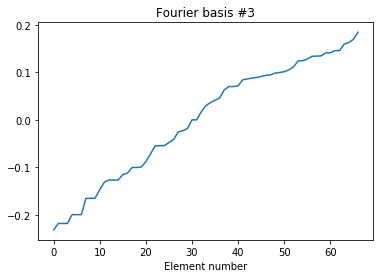

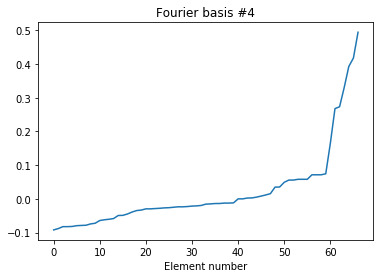

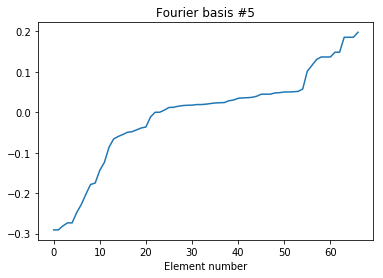

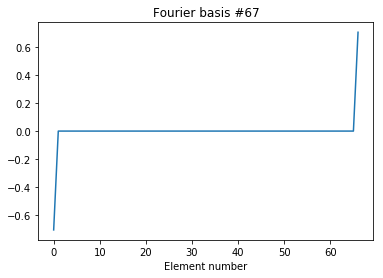

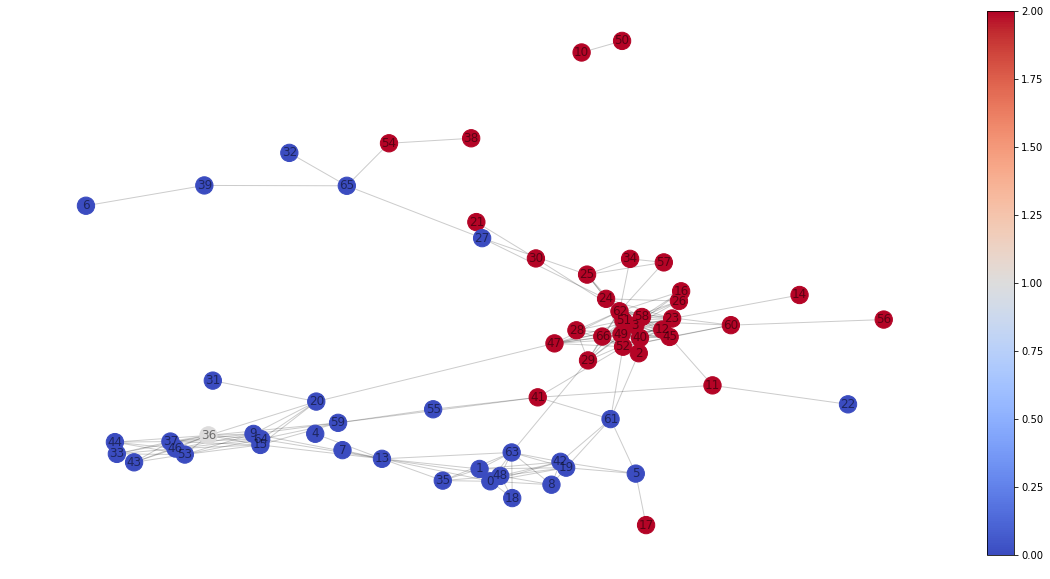

In [930]:
n_nodes = adjacency.shape[0]

def plot_fourier_basis(eigenvectors,index):
    plt.plot(np.arange(n_nodes),np.sort(eigenvectors[:,index]))
    plt.title("Fourier basis #{}".format(index+1))
    plt.xlabel("Element number")
    plt.show()
    
def GFT(x):
    return x @ U

def iGFT(x):
    return x @ U.T

def plot_graph(G,node_color):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(20,10))
    nx.draw_networkx_edges(G,pos,alpha=0.2)
    nc = nx.draw_networkx_nodes(G,pos,with_labels=True,node_color= node_color,cmap=plt.get_cmap('coolwarm'))
    nx.draw_networkx_labels(G, pos, alpha=0.5)
    plt.colorbar(nc)
    plt.axis('off')
    plt.show()

def plot_signal(signal,remove_0 = False):
    adjacency_temp = adjacency.copy()
    
    if remove_0:
        idx = np.nonzero(signal)[0]
        adjacency_temp = adjacency_temp[np.ix_(idx,idx)]
        signal = signal[idx]
        
    G = nx.from_numpy_matrix(adjacency_temp)
    plot_graph(G,np.round(signal,5))

e,U =  sc.linalg.eigh(laplacian)

plot_fourier_basis(U,2)
plot_fourier_basis(U,3)
plot_fourier_basis(U,4)
plot_fourier_basis(U,n_nodes-1)


dict_mapping = {'R':2,'D':0,'I':1}
labels = np.squeeze(np.vectorize(dict_mapping.get)(senators),axis=1)[nodes_to_keep]

plot_signal(labels)


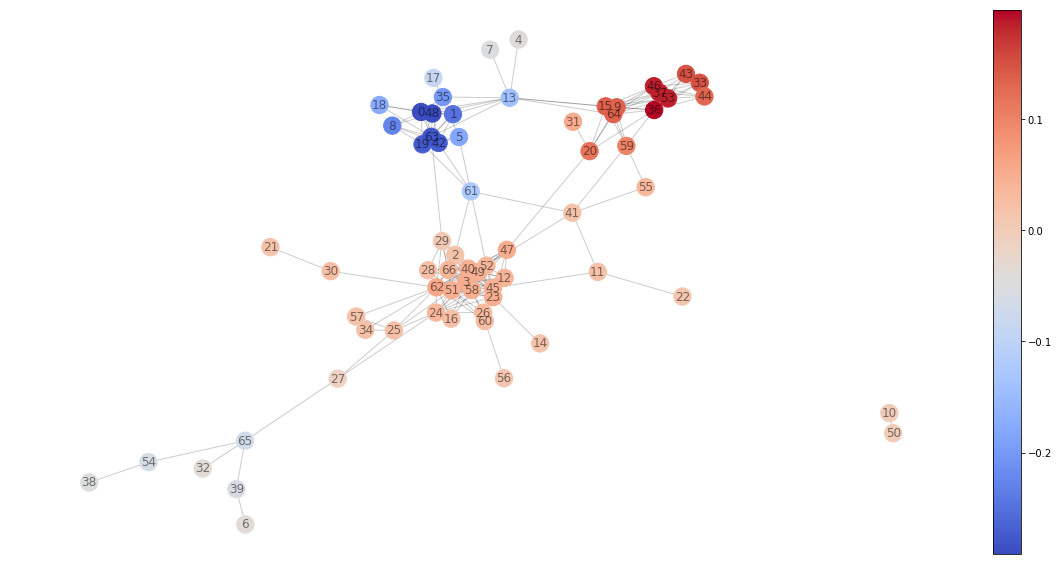

In [931]:
plot_signal(U[:,4])